# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from skimage.transform import resize
import imageio
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,3,4,6,7,8,10,12,14,15,16,18,19,22,23,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,84,84,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = image[:,20:,:]
                    #resizing the image
                    image = resize(image,(84,84,3), mode='constant', anti_aliasing=True)
                    
                    batch_data[folder,idx,:,:,0] =image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] =image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] =image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size) != 0:
            batch_data = np.zeros((batch_size,20,84,84,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = image[:,20:,:]
                    #resizing the image
                    image = resize(image,(84,84,3), mode='constant', anti_aliasing=True)
                    
                    batch_data[folder,idx,:,:,0] =image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] =image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] =image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from tensorflow.keras.regularizers import l2, l1


model = Sequential()
model.add(Conv3D(32, (3, 3,3), padding='same',
                 input_shape=[20, 84, 84, 3]))
model.add(Activation('relu'))
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 84, 84, 32)    2624      
_________________________________________________________________
activation (Activation)      (None, 20, 84, 84, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 18, 82, 82, 32)    27680     
_________________________________________________________________
activation_1 (Activation)    (None, 18, 82, 82, 32)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 41, 41, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 41, 41, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 9, 41, 41, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0)
callbacks_list = [checkpoint, LR]

W0510 14:58:12.982301 140055224874816 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 7.7912 - categorical_accuracy: 0.4077Source path =  Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 17.74419, saving model to model_init_2021-05-1014_57_35.256971/model-00001-7.79115-0.40774-17.74419-0.21094.h5
21/21 [==============================] - 228s 11s/step - loss: 7.7912 - categorical_accuracy: 0.4077 - val_loss: 17.7442 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 3.2213 - categorical_accuracy: 0.5521
Epoch 00002: val_loss did not improve from 17.74419
21/21 [==============================] - 233s 11s/step - loss: 3.2213 - categorical_accuracy: 0.5521 - val_loss: 22.5039 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.5950 - categorical_accuracy: 0.6562
Epoch 00003: val_loss improved from 

Epoch 24/30
21/21 [==============================] - ETA: 0s - loss: 0.0668 - categorical_accuracy: 0.9777
Epoch 00024: val_loss did not improve from 2.32372
21/21 [==============================] - 216s 10s/step - loss: 0.0668 - categorical_accuracy: 0.9777 - val_loss: 4.5670 - val_categorical_accuracy: 0.5156 - lr: 1.0000e-04
Epoch 25/30
21/21 [==============================] - ETA: 0s - loss: 0.0267 - categorical_accuracy: 0.9926
Epoch 00025: val_loss did not improve from 2.32372
21/21 [==============================] - 212s 10s/step - loss: 0.0267 - categorical_accuracy: 0.9926 - val_loss: 3.8651 - val_categorical_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 26/30
21/21 [==============================] - ETA: 0s - loss: 0.0519 - categorical_accuracy: 0.9851
Epoch 00026: val_loss did not improve from 2.32372
21/21 [==============================] - 218s 10s/step - loss: 0.0519 - categorical_accuracy: 0.9851 - val_loss: 4.4224 - val_categorical_accuracy: 0.6094 - lr: 1.0000e-05
Epoch 27/3

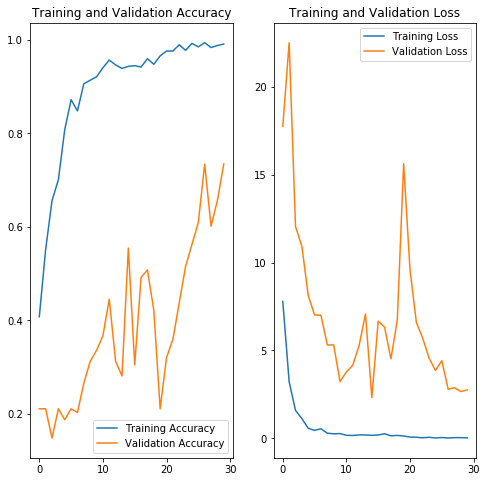

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()